In [1]:
# Implementing AEGIS.
# Importing necessary packages

import sys
sys.path.append("/home/users/cmo157/DGRB/")
import aegis
import numpy as np
import torch
import healpy as hp
import pickle as pk
from astropy import units as u
from astropy import constants as c
import matplotlib.pyplot as plt
from os import listdir
import os
import sys
from sbi.inference import SNLE, SNPE, simulate_for_sbi
from sbi import utils 
from sbi import analysis 
from sbi.inference import infer
from getdist import plots, MCSamples
sys.path.append("/home/users/cmo157/DGRB/sources/")
import DMsignal
from scipy.integrate import simpson
from scipy.stats import poisson
import json
%matplotlib inline

In [2]:
# Initializing the AEGIS

parameter_range = [[], []]
abundance_luminosity_and_spectrum_list = []
source_class_list = []
parameter_names = []
energy_range = [1e3, 1e5] #Mev
energy_range_gen = [energy_range[0]*0.5, energy_range[1]*1.5]
luminosity_range = 10.0**np.array([30, 37])
max_radius = 8.5+20*2 #kpc
exposure = 2000 * 10 * 1/5 #cm^2 yr 
flux_cut = 1e-9 #photons cm-2 s-1 (minimum flux)
angular_cut = np.pi 
angular_cut_gen = angular_cut
lat_cut = 0 
lat_cut_gen = lat_cut


In [3]:
# Generate AEGIS object
my_AEGIS = aegis.aegis(abundance_luminosity_and_spectrum_list, source_class_list, parameter_range, energy_range, luminosity_range, max_radius, exposure, angular_cut, lat_cut, flux_cut, energy_range_gen, angular_cut_gen, lat_cut_gen, verbose = False)

In [4]:
# Generating DM Signal
file_path_DM = "/home/users/cmo157/DGRB/data/dm_spectra/"
channel = "Tau"

My_DM = DMsignal.DMsignal(file_path_DM, channel)

DM_default_model = My_DM.get_default_model()

My_DM.set_spectrum_interpolator(My_DM.channel, mass_MeV=DM_default_model["mass_DM_MeV"])

desired_E = np.linspace(*energy_range, num=1001)

DM_spectrum = My_DM.get_dNdE(desired_E_MeV=desired_E, channel=My_DM.channel, mass_MeV=My_DM.mass_MeV)


In [5]:
# Useful constants

A_DM = DM_default_model["A_DM"]
mass_DM = DM_default_model["mass_DM_MeV"] #MeV
sig_v = 3e-26 # cm^3 s-1
beta = 1.9
A = 1.2e4 # M0-1 kpc-3
rs = 21 #kpc
r0 = 8.5 #kpc
Phi_PP = A_DM * sig_v * simpson(DM_spectrum, x=desired_E) / (8*np.pi * (mass_DM/1000)**2)
print(Phi_PP)
min_mass = 1 #M0


1.3980671735832397e-29


In [6]:
# Background Spectra
sys.path.append("/home/users/cmo157/DGRB/sources/")
import FermiBackgrounds

file_path = "/home/users/cmo157/DGRB"

My_Background = FermiBackgrounds.FermiBackgrounds(file_path)

background_energy, background_dNdE = My_Background.get_isotropic_background_spectrum()

def Background_E(energy, params):
    return(np.interp(energy, background_energy, background_dNdE))


In [7]:
def RL_function(r, L):
    # d2N / dLdV used to implement AEGIS
    L = np.asarray(L, dtype=float)
    r = np.asarray(r, dtype=float)
    r = np.clip(r, 1e-12, None)

    Lb, rb = np.broadcast_arrays(L, r)

    out = np.empty_like(Lb, dtype=float)
    
    it = np.nditer([Lb, rb, out], op_flags=[['readonly'], ['readonly'], ['writeonly']])

    for Li, ri, oi in it:

        Li = float(Li); ri = float(ri)
        L_tilde = Li / A_DM

        delta = np.log(Li) - 77.4 + 0.23*np.log(ri / 50) - np.log(8*np.pi*Phi_PP * 1e28)

        sigma = 0.74 + 0.011*np.log(ri / 50)

        mu = sigma**2 * ((1 - beta)/0.87) + delta

        m_scaled_min = 0.87*np.log(min_mass / 10**5)
        m_max = mu + 100*sigma
        m_values = np.linspace(m_scaled_min, m_max, 201)
        
        integral_int = np.exp(- (m_values - mu)**2 / (2*sigma**2))
        integral = simpson(integral_int, x=m_values)

        r_tilde = ri/21
        prefactor = 10**(5*(1-beta)) * A / (0.87 * Li * r_tilde * (1 + r_tilde)**2)
        exponent = np.exp((mu**2 - delta**2) / (2 * sigma**2)) / (np.sqrt(2.0 * np.pi) * sigma)
        val = prefactor*exponent*integral
        oi[...] = max(val, 0.0)
    return out


def RL_40deg(x, L, params):
    x = np.asarray(x, dtype=float)

    r = np.sqrt(x**2 + r0**2 - 2 * x * r0 * np.cos(40*np.pi / 180))
    return RL_function(r, L)

def spectrum(energy, params):
    return My_DM.get_dNdE(desired_E_MeV=energy, channel=My_DM.channel, mass_MeV=My_DM.mass_MeV)

In [8]:
def integrand(M):
    ri = 20
    r_tilde = ri/21
    Li = 1e34
    M_tilde = 0.87*np.log(M / 1e5)
    sigma = 0.74 + 0.011 * np.log(ri / 50)
    print(f'sigma = {sigma}')
    delta = np.log(Li) - 77.4 + 0.23*np.log(ri / 50) - np.log(8*np.pi*4e-30 * 1e28)
    print(f'delta = {delta}')
    mu = sigma**2 * (1 - beta) / 0.87 + delta 
    print(f'mu = {mu}')
    integrand = np.exp(-(M_tilde - mu)**2 / (2 * sigma**2)) / (np.sqrt(2*np.pi)*sigma)
    prefactor = (10**(5*(1-beta)) * A * np.exp((mu**2 - delta**2) / (2 * sigma**2))) / (0.87 * Li * r_tilde * (1 + r_tilde)**2 * np.sqrt(2*np.pi) * sigma) 
    return integrand * prefactor

sigma = 0.7299208019493842
delta = 0.6718506908054587
mu = 0.1206944386139771


(1e-80, 1e-32)

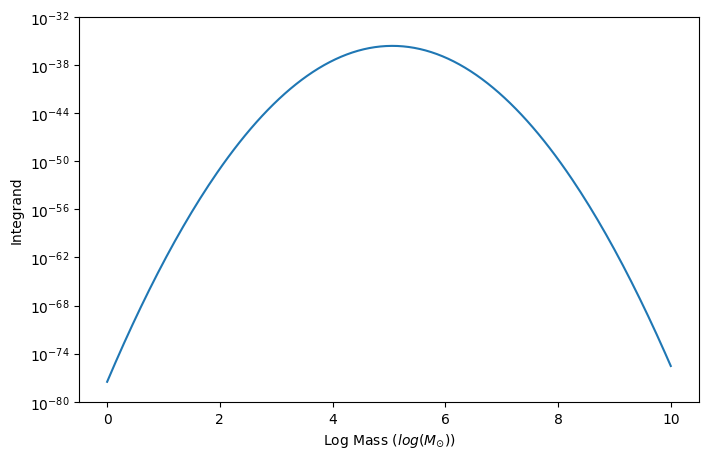

In [52]:
masses = np.geomspace(1, 1e10, 201) 
log_masses = np.log10(masses)

fig = plt.figure(figsize=(8, 5))
fig.set_dpi(100)
plt.plot(log_masses, integrand(masses))
plt.yscale("log")
plt.xlabel("Log Mass ($log(M_{\\odot})$)")
plt.ylabel("Integrand")
plt.ylim(1e-80, 1e-32)

(1e-38, 1e-32)

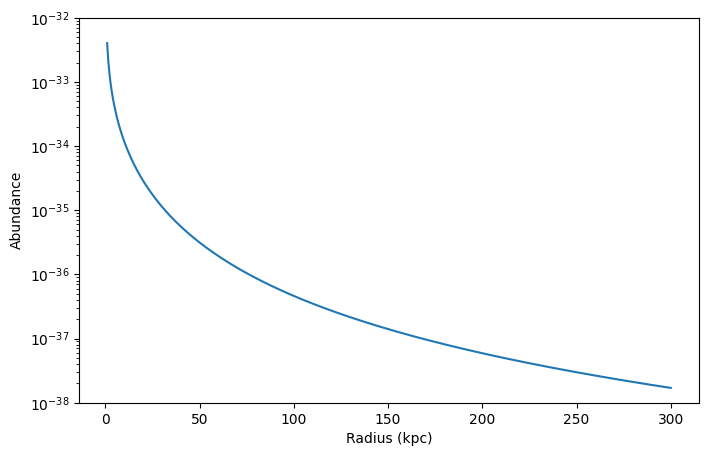

In [53]:
# Figure 2 in Nich Smith's honours
fixed_L = 1e34
varied_r = np.linspace(1, 300, 501)
abundance_fixed_L = RL_function(varied_r, fixed_L)

fig = plt.figure(figsize=(8, 5))
fig.set_dpi(100)
plt.plot(varied_r, abundance_fixed_L)
plt.yscale("log")
plt.xlabel('Radius (kpc)')
plt.ylabel("Abundance")
plt.ylim(1e-38, 1e-32)


In [15]:
def L(l, params):
    M, r = params
    lnM = np.log(M/1e5)
    lnr = np.log(r/50)
    ln_L_exp = 77.4 + 0.87*lnM - 0.23*lnr + np.log(8*np.pi*Phi_PP*1e28)
    sigma = 0.74 - 0.003*lnM + 0.011*lnr 
    lnL = np.log(l)
    prefactor = 1/(np.sqrt(2*np.pi)*sigma*l)
    exponent = -((lnL - ln_L_exp)**2) / (2*sigma**2)
    return prefactor*np.exp(exponent)


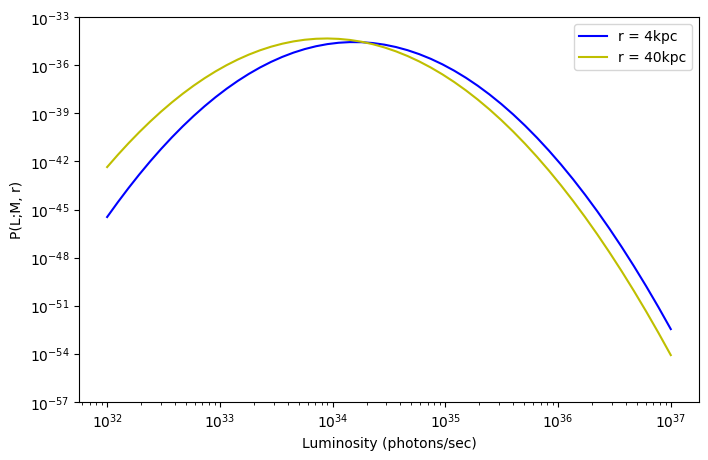

In [51]:
# Figure 3 in Nich Smith's Honours

varied_L = 10**np.geomspace(32, 37)
fixed_r = [4, 40]
Mass = 1e5

abundance_fixed_r = [L(varied_L, [Mass, r]) for r in fixed_r]

fig = plt.figure(figsize=(8, 5))
plt.plot(varied_L, abundance_fixed_r[0], c='b', label='r = 4kpc')
plt.plot(varied_L, abundance_fixed_r[1], c='y', label='r = 40kpc')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Luminosity (photons/sec)')
plt.ylabel('P(L;M, r)')
plt.ylim(1e-57, 1e-33)
fig.set_dpi(100)

### To create new dark matter photon data

In [58]:
als = [RL_40deg, spectrum]
my_AEGIS.abun_lum_spec = [als]
my_AEGIS.source_class_list = ['isotropic_faint_single_spectrum']

input_params = []

sources = my_AEGIS.create_sources(input_params, grains=int(1e4), epsilon=1e-3)


print(f"number of sources generated: {len(sources['distances'])}")

photon_info = my_AEGIS.generate_photons_from_sources(input_params, sources)

print(f"Number of photons generated: {len(photon_info['energies'])}")

number of sources generated: 96838890
Number of photons generated: 87363


### This opens the currently saved photon_info data

In [40]:

photon_info_file_path = '/home/users/cmo157/projectvenv/photon_info.npz'
loaded_data = np.load(photon_info_file_path)
bg_dm_photon_info = {key: loaded_data[key] for key in loaded_data}

# Only Dark Matter
photon_info_dm_file_path = '/home/users/cmo157/projectvenv/photon_info_DM.npz'
loaded_data2 = np.load(photon_info_dm_file_path)
photon_info = {key: loaded_data2[key] for key in loaded_data2}

In [34]:
# Constants

N_side = 2**6
N_pix = 12*N_side**2
pix_i = np.linspace(0, N_pix-1, N_pix, dtype='int')
center_mask = 60
lat_mask = 30

mincount = 1
maxcount = 30
N_Ebins = 10
N_countbins = 15
Ebinspace = 'log'
countbinspace = 'linear'
Ebins = np.geomspace(my_AEGIS.Emin_mask + 0.1, my_AEGIS.Emax_mask + 0.1, N_Ebins + 1) - 0.1


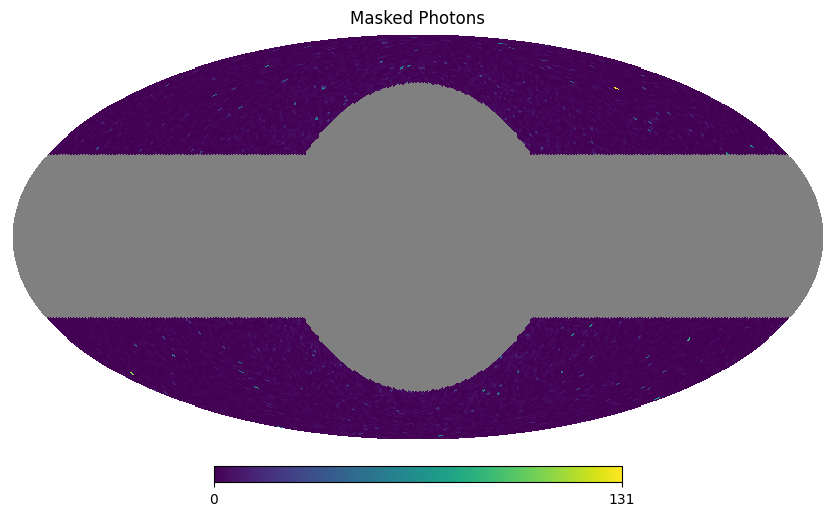

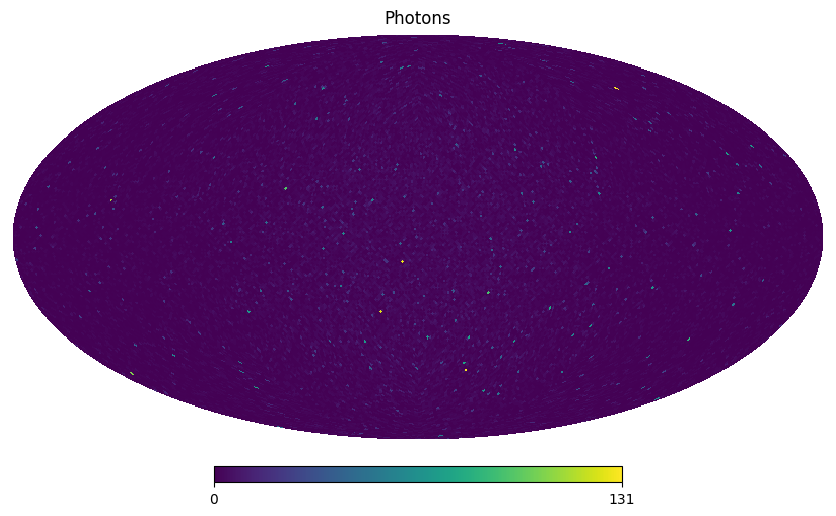

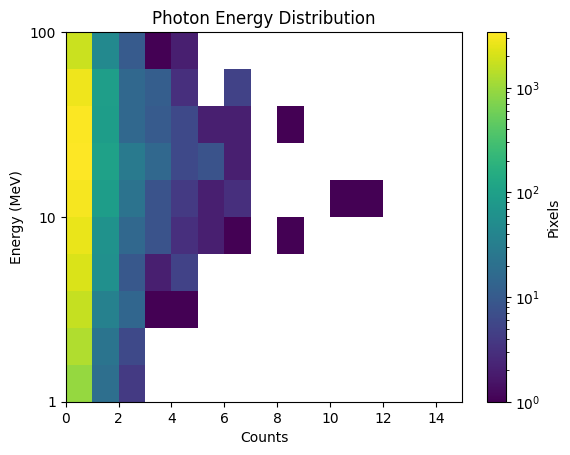

In [ ]:
# Plotting just the Dark Matter contribution to the sky
from matplotlib.colors import LogNorm


heatmap = np.histogram(hp.ang2pix(N_side, photon_info['angles'][:,0], photon_info['angles'][:,1]), bins = 12*N_side**2, range = [0, 12*N_side**2])
masked_map = np.where(np.logical_and(hp.rotator.angdist(np.array([np.pi/2, 0]), hp.pix2ang(N_side, pix_i)) >= center_mask*u.deg.to('rad'), np.abs(np.pi/2 - hp.pix2ang(N_side, pix_i)[0]) >= lat_mask*u.deg.to('rad')), heatmap[0], hp.UNSEEN)
hp.mollview(masked_map, title="Masked Photons")
hp.mollview(heatmap[0], title="Photons")




roi_pix_i = np.where(np.logical_and(hp.rotator.angdist(np.array([np.pi/2, 0]), hp.pix2ang(N_side, pix_i)) >= center_mask*u.deg.to('rad'), np.abs(np.pi/2 - hp.pix2ang(N_side, pix_i)[0]) >= lat_mask*u.deg.to('rad')))[0]
roi_map = my_AEGIS.get_roi_map_summary(photon_info = photon_info, N_side = N_side, N_Ebins = N_Ebins, Ebinspace = Ebinspace, roi_pix_i = roi_pix_i)
summary = my_AEGIS.get_counts_histogram_from_roi_map(roi_map, mincount = mincount, maxcount = maxcount, N_countbins = N_countbins, countbinspace = countbinspace)
summary = np.transpose(summary)

fig, ax = plt.subplots()
# Linear histogram:
# plt.hist(photon_info['energies'], bins=30, range=[1e3, 1e5])
# Logarithmic histogram:
# plt.hist(photon_info['energies'], bins=logbins)
mesh = ax.pcolormesh(summary, norm=LogNorm())
ax.set_ylabel('Energy (MeV)')
ax.set_xlabel('Counts')
#ax.set_yscale('log')
ax.set_title('Photon Energy Distribution')
ax.set_yticks([0, 5, 10])
ax.set_yticklabels([1, 10, 100])
fig.colorbar(mesh, label='Pixels')
plt.show()

In [36]:
# I need to implement backgrounds aswell.
# make new AEGIS? then add the two fluxes? 
# Initialisation is the same as before
my_AEGIS_2 = aegis.aegis(abundance_luminosity_and_spectrum_list, source_class_list, parameter_range, energy_range, luminosity_range, max_radius, exposure, angular_cut, lat_cut, flux_cut, energy_range_gen, angular_cut_gen, lat_cut_gen, verbose = False)

bg_als = [Background_E]
my_AEGIS_2.abun_lum_spec = [bg_als]
my_AEGIS_2.source_class_list = ['isotropic_diffuse']

input_params = []

sources_bg = my_AEGIS_2.create_sources(input_params, grains=int(1e4), epsilon=1e-3)


print(f"number of sources generated: {len(sources_bg['distances'])}")

photon_info_bg = my_AEGIS_2.generate_photons_from_sources(input_params, sources_bg)

print(f"Number of photons generated: {len(photon_info_bg['energies'])}")


number of sources generated: 0
Number of photons generated: 2050695


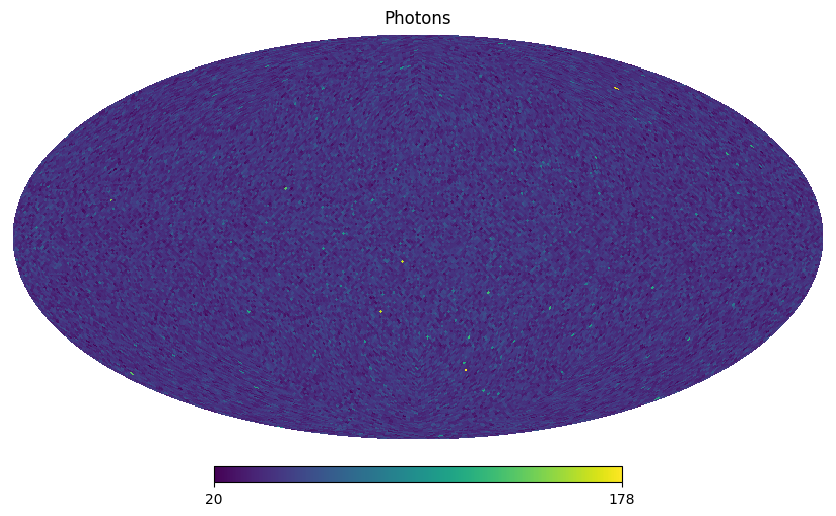

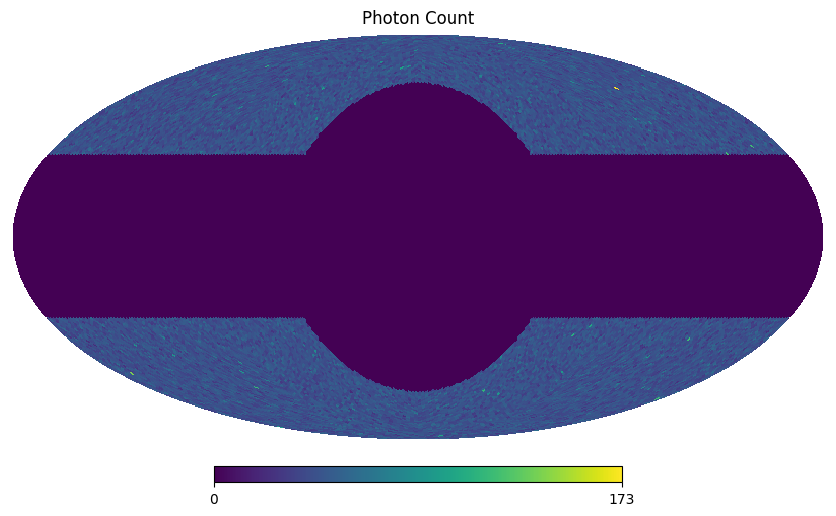

In [46]:

bg_heatmap =  np.histogram(hp.ang2pix(N_side, photon_info_bg['angles'][:,0], photon_info_bg['angles'][:,1]), bins = 12*N_side**2, range = [0, 12*N_side**2])
all_angles = np.transpose(np.array([np.append(photon_info['angles'][:,0], photon_info_bg['angles'][:,0]), np.append(photon_info['angles'][:,1], photon_info_bg['angles'][:,1])]))
all_energy = np.append(photon_info['energies'], photon_info_bg['energies'])
bg_dm_photon_info = {'angles': all_angles, 'energies': all_energy}


# Now lets use a mask too
full_heatmap = np.histogram(hp.ang2pix(N_side, bg_dm_photon_info['angles'][:,0], bg_dm_photon_info['angles'][:,1]), bins = 12*N_side**2, range = [0, 12*N_side**2])
full_masked_map = np.where(np.logical_and(hp.rotator.angdist(np.array([np.pi/2, 0]), hp.pix2ang(N_side, pix_i)) >= center_mask*u.deg.to('rad'), np.abs(np.pi/2 - hp.pix2ang(N_side, pix_i)[0]) >= lat_mask*u.deg.to('rad')), full_heatmap[0], 0)

hp.mollview(full_heatmap[0], title='Photons')
hp.mollview(full_masked_map, title='Photon Count')

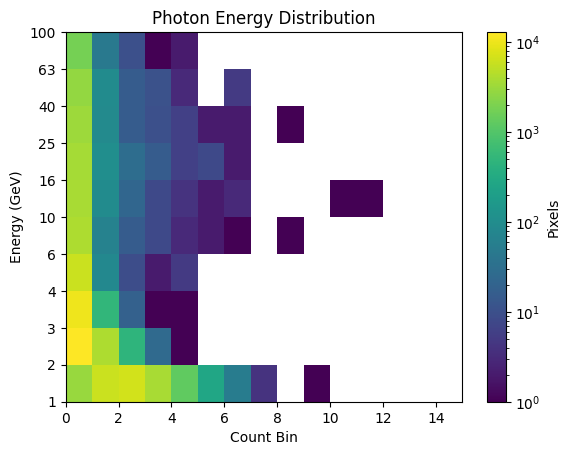

In [45]:

roi_pix_i_bg = np.where(np.logical_and(hp.rotator.angdist(np.array([np.pi/2, 0]), hp.pix2ang(N_side, pix_i)) >= center_mask*u.deg.to('rad'), np.abs(np.pi/2 - hp.pix2ang(N_side, pix_i)[0]) >= lat_mask*u.deg.to('rad')))[0]
roi_map_bg = my_AEGIS.get_roi_map_summary(photon_info = photon_info_bg, N_side = N_side, N_Ebins = N_Ebins, Ebinspace = Ebinspace, roi_pix_i = roi_pix_i_bg)
summary_bg = my_AEGIS.get_counts_histogram_from_roi_map(roi_map_bg, mincount = mincount, maxcount = maxcount, N_countbins = N_countbins, countbinspace = countbinspace)
summary_bg = np.transpose(summary_bg)
summary_tot = summary_bg + summary
# roi_map_tot = my_AEGIS.get_roi_map_summary(photon_info = bg_dm_photon_info, N_side = N_side, N_Ebins = N_Ebins, Ebinspace = Ebinspace, roi_pix_i = roi_pix_i_bg)
# summary_tot = my_AEGIS.get_counts_histogram_from_roi_map(roi_map_tot, mincount = mincount, maxcount = maxcount, N_countbins = N_countbins, countbinspace = countbinspace)


fig, ax = plt.subplots()
# Linear histogram:
# plt.hist(photon_info['energies'], bins=30, range=[1e3, 1e5])
# Logarithmic histogram:
# plt.hist(photon_info['energies'], bins=logbins)
mesh = ax.pcolormesh(summary_tot, norm=LogNorm())
ax.set_ylabel('Energy (GeV)')
ax.set_xlabel('Count Bin')
#ax.set_yscale('log')
ax.set_title('Photon Energy Distribution')
ax.set_yticks(np.linspace(0, N_Ebins, N_Ebins+1))
ax.set_yticklabels(np.round(Ebins/1000).astype('int'))
fig.colorbar(mesh, label='Pixels')
plt.show()

In [62]:
# Saving photon info so that I don't have to run it every time.
np.savez(photon_info_file_path, **bg_dm_photon_info)

np.savez(photon_info_dm_file_path, **photon_info)

In [ ]:
def distance(h1, h2):
    metric = (h1 - h2)**2 / (h1 + h2)
    dis = np.sqrt(np.sum(metric))
    return dis

